In [1]:
import os
import time
import math
import argparse
import json
from pathlib import Path

import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms
from torchvision import datasets

CLASS_NAMES = ["cider","wheat","lager","ipa","stout","not_beer"]


In [2]:
class BeerClassifier(nn.Module):
    def __init__(self, dropout=0.2, num_classes=6):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(3, 64),
            block(64, 128),
            block(128, 256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.1)),            # slightly larger
    transforms.RandomCrop(IMG_SIZE),                   # crop to final size
    transforms.RandomHorizontalFlip(p=0.5),            # bottles left/right
    transforms.RandomRotation(15),                     # small tilt
    transforms.ColorJitter(brightness=0.2,              # lighting variations
                           contrast=0.2,
                           saturation=0.15,
                           hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet norms
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# For something like inference on a fixed size model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
!ls -l sample_data/photos/not\ beer


total 136960
-rw-r--r-- 1 root root    7709 Aug  9 12:26 ace-cider-the-california-cider-company-ace-pineapple-cider_ace-cider-the-california-cider-company-ace-pineapple-cider_003.jpg_crop_2.jpg
-rw-r--r-- 1 root root  816541 Aug  9 12:26 ace-cider-the-california-cider-company-ace-pineapple-cider_ace-cider-the-california-cider-company-ace-pineapple-cider_006.jpg_crop_0.jpg
-rw-r--r-- 1 root root  165514 Aug  9 12:26 ace-cider-the-california-cider-company-ace-pineapple-cider_ace-cider-the-california-cider-company-ace-pineapple-cider_006.jpg_crop_2.jpg
-rw-r--r-- 1 root root  166564 Aug  9 12:26 ace-cider-the-california-cider-company-ace-pineapple-cider_ace-cider-the-california-cider-company-ace-pineapple-cider_009.jpg_crop_2.jpg
-rw-r--r-- 1 root root 1946358 Aug  9 12:26 ace-cider-the-california-cider-company-ace-pineapple-cider_ace-cider-the-california-cider-company-ace-pineapple-cider_013.jpg_crop_1.jpg
-rw-r--r-- 1 root root  313151 Aug  9 12:26 ace-cider-the-california-cider-company

In [8]:
DATA_DIR = Path("sample_data/photos")  # <-- CHANGE THIS to your actual path
N_AUG_PER_IMAGE = 1                 # how many augmented versions per original
IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"]

# === Define augmentations ===
augment = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

# === Go through each class directory ===
for class_dir in DATA_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    # Create the "augmented/" subfolder inside each class dir
    aug_dir = class_dir

    for img_path in tqdm(list(class_dir.glob("*")), desc=f"Augmenting {class_dir.name}"):
        if not img_path.is_file() or img_path.suffix.lower() not in IMAGE_EXTENSIONS:
            continue
        if "augmented" in str(img_path):  # skip already-augmented files
            continue

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Skipping {img_path.name}: {e}")
            continue

        for i in range(N_AUG_PER_IMAGE):
            aug_img = augment(img)
            new_name = f"{img_path.stem}_aug{i}{img_path.suffix}"
            aug_img.save(aug_dir / new_name)

Augmenting ipa: 100%|██████████| 494/494 [00:15<00:00, 31.64it/s]


In [9]:
!rm -rf /content/sample_data/photos/.ipynb_checkpoints

dataset = datasets.ImageFolder(root="/content/sample_data/photos", transform=transform)

In [10]:
train_ratio, val_ratio = 0.8, 0.1
train_size = int(train_ratio * len(dataset))
val_size   = int(val_ratio * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# --- Assign transforms ---
train_dataset.dataset.transform = train_transform  # train set gets aug
val_dataset.dataset.transform   = eval_transform   # val set = eval tfms
test_dataset.dataset.transform  = eval_transform   # test set = eval tfms

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=2)


In [11]:
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train samples: 5488
Validation samples: 686
Test samples: 686


In [12]:
def train_and_evaluate(lr, weight_decay, dropout, patience,
                       max_epochs=25, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = BeerClassifier(dropout=dropout).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Step on validation accuracy (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=False
    )

    best_acc = 0.0
    best_state = None
    epochs_without_improve = 0

    print(f"\n=== Training with lr={lr:.6f}, wd={weight_decay:.6f}, dr={dropout:.3f}, patience={patience} ===")
    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        total_train, correct_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = logits.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # ---- Validate ----
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = correct_val / total_val if total_val > 0 else 0.0

        # LR schedule on metric
        scheduler.step(val_acc)

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            epochs_without_improve = 0
            improved = "✅"
        else:
            epochs_without_improve += 1
            improved = "—"

        # Current LR
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        print(f"Epoch [{epoch:02d}/{max_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | Best: {best_acc:.4f} {improved} | "
              f"LR: {current_lr:.6f}")

        if epochs_without_improve >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}")
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return best_acc


In [13]:
lr_range = (0.001, 0.0001)
wd_range = (1e-6, 1e-3)
dropout_range = (0.1, 0.6)
patience_range = (2, 4)

num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate(**params, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000220, wd=0.000074, dr=0.283, patience=4 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [01/5] | Train Loss: 1.3797 | Train Acc: 0.4701 | Val Acc: 0.4461 | Best: 0.4461 ✅ | LR: 0.000220
Epoch [02/5] | Train Loss: 1.2252 | Train Acc: 0.5430 | Val Acc: 0.6020 | Best: 0.6020 ✅ | LR: 0.000220
Epoch [03/5] | Train Loss: 1.1597 | Train Acc: 0.5678 | Val Acc: 0.5394 | Best: 0.6020 — | LR: 0.000220
Epoch [04/5] | Train Loss: 1.1108 | Train Acc: 0.5862 | Val Acc: 0.6093 | Best: 0.6093 ✅ | LR: 0.000220
Epoch [05/5] | Train Loss: 1.0831 | Train Acc: 0.5986 | Val Acc: 0.6254 | Best: 0.6254 ✅ | LR: 0.000220
[1/10] lr=0.000220, wd=0.000074, dr=0.283, pt=4 -> val acc=0.6254

=== Training with lr=0.000301, wd=0.000024, dr=0.487, patience=3 ===
Epoch [01/5] | Train Loss: 1.4209 | Train Acc: 0.4457 | Val Acc: 0.4810 | Best: 0.4810 ✅ | LR: 0.000301
Epoch [02/5] | Train Loss: 1.2666 | Train Acc: 0.5204 | Val Acc: 0.5904 | Best: 0.5904 ✅ | LR: 0.000301
Epoch [03/5] | Train Loss: 1.2001 | Train Acc: 0.5570 | Val Acc: 0.5845 | Best: 0.5904 — | LR: 0.000301
Epoch [04/5] | Train Loss: 1.167

Epoch 1/50 | Train Loss: 1.4034 | Validation Accuracy: 46.21%
Epoch 2/50 | Train Loss: 1.2518 | Validation Accuracy: 55.10%
Epoch 3/50 | Train Loss: 1.2063 | Validation Accuracy: 56.56%
Epoch 4/50 | Train Loss: 1.1469 | Validation Accuracy: 57.58%
Epoch 5/50 | Train Loss: 1.1238 | Validation Accuracy: 59.91%
Epoch 6/50 | Train Loss: 1.1114 | Validation Accuracy: 61.52%
Epoch 7/50 | Train Loss: 1.0785 | Validation Accuracy: 56.27%
Epoch 8/50 | Train Loss: 1.0531 | Validation Accuracy: 59.33%
Epoch 9/50 | Train Loss: 1.0295 | Validation Accuracy: 62.97%
Epoch 10/50 | Train Loss: 1.0335 | Validation Accuracy: 62.39%
Epoch 11/50 | Train Loss: 0.9973 | Validation Accuracy: 64.29%
Epoch 12/50 | Train Loss: 1.0034 | Validation Accuracy: 65.89%
Epoch 13/50 | Train Loss: 0.9779 | Validation Accuracy: 63.70%
Epoch 14/50 | Train Loss: 0.9731 | Validation Accuracy: 65.01%
Epoch 15/50 | Train Loss: 0.9678 | Validation Accuracy: 64.87%
Epoch 16/50 | Train Loss: 0.9569 | Validation Accuracy: 63.56%
E

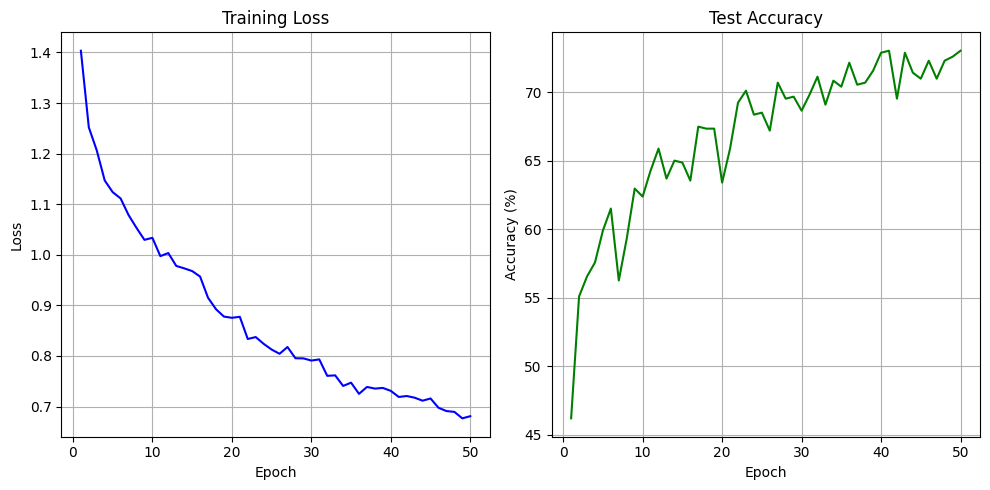

In [14]:
best_lr, best_wd, best_dropout, best_patience = best_params['lr'], best_params['weight_decay'], best_params['dropout'], best_params['patience'] #From earlier because we dont want to run the validaion cell a lot of time

model = BeerClassifier(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 50
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
# === Save the best model weights ===
model_save_path = "best_beer_classifier.pth"
torch.save(best_model_state, model_save_path)
print(f"Best model weights saved to {model_save_path}")

Best model weights saved to best_beer_classifier.pth
